<a href="https://colab.research.google.com/github/abhayvershwal/major-project/blob/master/Cropdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import imghdr
from tensorflow.keras import models, layers
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [ ]:
trainingdataset=tf.keras.preprocessing.image_dataset_from_directory('/content/sample_data/Training Dataset',
seed=123,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

NotFoundError: Could not find directory /content/sample_data/Training Dataset

In [ ]:
class_names = trainingdataset.class_names
class_names

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in trainingdataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(trainingdataset)

38

In [ ]:
train_size = 0.8
len(trainingdataset)*train_size

30.400000000000002

In [ ]:
train_ds = trainingdataset.take(30)
len(train_ds)

30

In [ ]:
test_ds = trainingdataset.skip(30)
len(test_ds)

8

In [ ]:
val_size=0.1
len(trainingdataset)*val_size

3.8000000000000003

In [ ]:
val_ds = trainingdataset.take(3)
len(val_ds)

3

In [ ]:
len(train_ds)

30

In [ ]:
len(test_ds)

8

In [ ]:
len(val_ds)

3

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(trainingdataset)

In [ ]:
len(train_ds)

30

In [ ]:
len(val_ds)

3

In [ ]:
len(test_ds)

5

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_2 (Flatten)         (32, 246016)             

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
30/30 [==============================] - 112s 4s/step - loss: 0.9399 - accuracy: 0.8317 - val_loss: 0.3583 - val_accuracy: 0.7708
Epoch 2/5
30/30 [==============================] - 106s 3s/step - loss: 0.2870 - accuracy: 0.8658 - val_loss: 0.3569 - val_accuracy: 0.8333
Epoch 3/5
30/30 [==============================] - 107s 4s/step - loss: 0.2368 - accuracy: 0.8988 - val_loss: 0.3127 - val_accuracy: 0.8438
Epoch 4/5
30/30 [==============================] - 107s 4s/step - loss: 0.2130 - accuracy: 0.9116 - val_loss: 0.1634 - val_accuracy: 0.9271
Epoch 5/5
30/30 [==============================] - 107s 4s/step - loss: 0.1776 - accuracy: 0.9286 - val_loss: 0.1033 - val_accuracy: 0.9792


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 5s 818ms/step - loss: 0.1325 - accuracy: 0.9375


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: bacterial
1/1 [==============================] - 1s 955ms/step
predicted label: bacterial


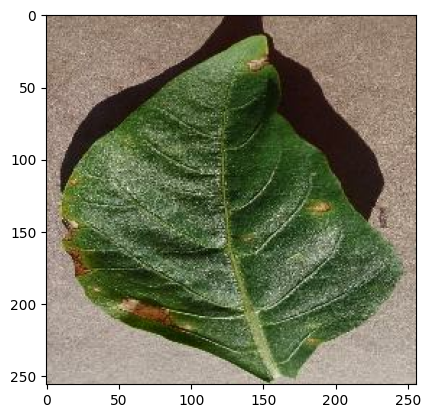

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])